<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu4/Minggu4_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install xgboost -q

# Import Library

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix,
    classification_report, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✓ Using device: {device}')

✓ Using device: cuda


# Config


In [ ]:
# K-fold settings
K_FOLDS = 5
RANDOM_STATE = 42

# BiLSTM hyperparameters (use your best from Week 3)
LSTM_CONFIG = {
    'input_dim': 1280,
    'hidden_dim': 512,      # ← Adjust to your best config
    'dropout': 0.3,         # ← Adjust to your best config
    'output_dim': 2,
    'lr': 0.002,            # ← Adjust to your best config
    'batch_size': 16,       # ← Adjust to your best config
    'epochs': 30,
    'patience': 5
}

# MLP hyperparameters (use your best from Week 4)
MLP_CONFIG = {
    'input_dim': 1280,
    'hidden_dims': [512, 256, 128, 64, 32],  # ← Adjust to your best config
    'dropout': 0.2,                           # ← Adjust to your best config
    'output_dim': 2,
    'lr': 0.0005,                              # ← Adjust to your best config
    'batch_size': 64,                         # ← Adjust to your best config
    'epochs': 30,
    'patience': 5
}

# Define Model

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out[:, -1, :])
        return self.fc(x)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Load Embedded dataset

In [ ]:
# Load ESM-1b embeddings (for BiLSTM)
X_train_esm1b = torch.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_train.pt').numpy()
y_train = np.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_train.npy')
X_test_esm1b = torch.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_test.pt').numpy()
y_test = np.load('/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_test.npy')

# Load ESM-DBP embeddings (for MLP)
X_train_mlp = np.load('/content/drive/MyDrive/esm_dbp_embeddings/X_train.npy')
X_test_mlp = np.load('/content/drive/MyDrive/esm_dbp_embeddings/X_test.npy')

print(f"✓ Data loaded:")
print(f"  ESM-1b  - Train: {X_train_esm1b.shape}, Test: {X_test_esm1b.shape}")
print(f"  ESM-DBP - Train: {X_train_mlp.shape}, Test: {X_test_mlp.shape}")
print(f"  Labels  - Train: {y_train.shape}, Test: {y_test.shape}")
print(f"  Class distribution: {np.bincount(y_train)}")

✓ Data loaded:
  ESM-1b  - Train: (985, 1280), Test: (186, 1280)
  ESM-DBP - Train: (985, 1280), Test: (186, 1280)
  Labels  - Train: (985,), Test: (186,)
  Class distribution: [545 440]


# Training function

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, config, device='cuda'):
    """Train model with early stopping"""

    # Create data loaders
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    val_dataset = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.long)
    )

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Setup
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0
    best_state = None
    bad_epochs = 0

    # Training loop
    for epoch in range(1, config['epochs'] + 1):
        # Train
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validate
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(y_batch.cpu().numpy())

        val_f1 = f1_score(all_targets, all_preds)

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict().copy()
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= config['patience']:
                print(f"      Early stopping at epoch {epoch} (Best F1: {best_val_f1:.4f})")
                break

    # Load best weights
    model.load_state_dict(best_state)
    return model, best_val_f1

In [ ]:
def get_predictions(model, X_data, device='cuda', batch_size=64):
    """Get probability predictions"""
    dataset = TensorDataset(torch.tensor(X_data, dtype=torch.float32))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    model.eval()
    with torch.no_grad():
        for (X_batch,) in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)

    return np.vstack(all_probs)

## K-Fold Train model

In [ ]:
# Storage
meta_train_lstm = np.zeros((len(X_train_esm1b), 2))
meta_train_mlp = np.zeros((len(X_train_mlp), 2))
meta_test_lstm_folds = []
meta_test_mlp_folds = []

# K-fold split
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_performance = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_esm1b, y_train), 1):
    print(f"\n{'='*70}")
    print(f"FOLD {fold}/{K_FOLDS}")
    print(f"{'='*70}")
    print(f"Train: {len(train_idx)} samples, Val: {len(val_idx)} samples")

    # Split data for this fold
    X_train_fold_lstm = X_train_esm1b[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold_lstm = X_train_esm1b[val_idx]
    y_val_fold = y_train[val_idx]

    X_train_fold_mlp = X_train_mlp[train_idx]
    X_val_fold_mlp = X_train_mlp[val_idx]

    # TRAIN BiLSTM
    print(f"\n  🔄 Training BiLSTM...")
    model_lstm = BiLSTMModel(
        LSTM_CONFIG['input_dim'],
        LSTM_CONFIG['hidden_dim'],
        LSTM_CONFIG['dropout'],
        LSTM_CONFIG['output_dim']
    ).to(device)

    model_lstm, lstm_best_f1 = train_model(
        model_lstm,
        X_train_fold_lstm, y_train_fold,
        X_val_fold_lstm, y_val_fold,
        LSTM_CONFIG,
        device
    )
    print(f"  ✓ BiLSTM trained - Val F1: {lstm_best_f1:.4f}")

    # TRAIN MLP
    print(f"\n  🔄 Training MLP...")
    model_mlp = MLPClassifier(
        MLP_CONFIG['input_dim'],
        MLP_CONFIG['hidden_dims'],
        MLP_CONFIG['dropout'],
        MLP_CONFIG['output_dim']
    ).to(device)

    model_mlp, mlp_best_f1 = train_model(
        model_mlp,
        X_train_fold_mlp, y_train_fold,
        X_val_fold_mlp, y_val_fold,
        MLP_CONFIG,
        device
    )
    print(f"  ✓ MLP trained - Val F1: {mlp_best_f1:.4f}")

    print(f"\n  📊 Getting predictions...")

    # Out-of-fold predictions (for meta-training)
    lstm_val_probs = get_predictions(model_lstm, X_val_fold_lstm, device)
    mlp_val_probs = get_predictions(model_mlp, X_val_fold_mlp, device)

    meta_train_lstm[val_idx] = lstm_val_probs
    meta_train_mlp[val_idx] = mlp_val_probs

    # Test predictions (will be averaged across folds)
    lstm_test_probs = get_predictions(model_lstm, X_test_esm1b, device)
    mlp_test_probs = get_predictions(model_mlp, X_test_mlp, device)

    meta_test_lstm_folds.append(lstm_test_probs)
    meta_test_mlp_folds.append(mlp_test_probs)

    # Store fold performance
    fold_performance.append({
        'fold': fold,
        'lstm_f1': lstm_best_f1,
        'mlp_f1': mlp_best_f1
    })

    print(f"\n  ✅ Fold {fold} complete!")

# Average test predictions across folds
meta_test_lstm = np.mean(meta_test_lstm_folds, axis=0)
meta_test_mlp = np.mean(meta_test_mlp_folds, axis=0)

print("\n" + "="*70)
print("✓ K-FOLD TRAINING COMPLETE!")
print("="*70)
print(f"Meta-train shape: {meta_train_lstm.shape}")
print(f"Meta-test shape: {meta_test_lstm.shape}")

# Show fold performance summary
fold_df = pd.DataFrame(fold_performance)
print("\nFold Performance Summary:")
print(fold_df.to_string(index=False))
print(f"\nBiLSTM Avg F1: {fold_df['lstm_f1'].mean():.4f} ± {fold_df['lstm_f1'].std():.4f}")
print(f"MLP Avg F1:    {fold_df['mlp_f1'].mean():.4f} ± {fold_df['mlp_f1'].std():.4f}")



FOLD 1/5
Train: 788 samples, Val: 197 samples

  🔄 Training BiLSTM...
      Early stopping at epoch 8 (Best F1: 0.8497)
  ✓ BiLSTM trained - Val F1: 0.8497

  🔄 Training MLP...
      Early stopping at epoch 15 (Best F1: 0.8587)
  ✓ MLP trained - Val F1: 0.8587

  📊 Getting predictions...

  ✅ Fold 1 complete!

FOLD 2/5
Train: 788 samples, Val: 197 samples

  🔄 Training BiLSTM...
      Early stopping at epoch 12 (Best F1: 0.8276)
  ✓ BiLSTM trained - Val F1: 0.8276

  🔄 Training MLP...
      Early stopping at epoch 21 (Best F1: 0.8475)
  ✓ MLP trained - Val F1: 0.8475

  📊 Getting predictions...

  ✅ Fold 2 complete!

FOLD 3/5
Train: 788 samples, Val: 197 samples

  🔄 Training BiLSTM...
      Early stopping at epoch 8 (Best F1: 0.8280)
  ✓ BiLSTM trained - Val F1: 0.8280

  🔄 Training MLP...
      Early stopping at epoch 10 (Best F1: 0.8571)
  ✓ MLP trained - Val F1: 0.8571

  📊 Getting predictions...

  ✅ Fold 3 complete!

FOLD 4/5
Train: 788 samples, Val: 197 samples

  🔄 Training Bi

# Create Meta Data-set

In [ ]:
print("CREATING META-DATASET")
print("="*70)

X_meta_train = np.hstack([meta_train_lstm, meta_train_mlp])  # (n_train, 4)
X_meta_test = np.hstack([meta_test_lstm, meta_test_mlp])     # (n_test, 4)

print(f"X_meta_train: {X_meta_train.shape}")
print(f"X_meta_test:  {X_meta_test.shape}")

print("\nFirst 5 meta-training samples:")
print(f"{'BiLSTM_p0':<12} {'BiLSTM_p1':<12} {'MLP_p0':<12} {'MLP_p1':<12} {'Label':<6}")
print("-" * 60)
for i in range(5):
    print(f"{meta_train_lstm[i,0]:<12.4f} {meta_train_lstm[i,1]:<12.4f} {meta_train_mlp[i,0]:<12.4f} {meta_train_mlp[i,1]:<12.4f} {y_train[i]:<6}")


CREATING META-DATASET
X_meta_train: (985, 4)
X_meta_test:  (186, 4)

First 5 meta-training samples:
BiLSTM_p0    BiLSTM_p1    MLP_p0       MLP_p1       Label 
------------------------------------------------------------
0.9949       0.0051       0.8713       0.1287       0     
0.9991       0.0009       0.9935       0.0065       0     
1.0000       0.0000       0.9982       0.0018       0     
0.9999       0.0001       0.9985       0.0015       0     
0.9978       0.0022       0.9994       0.0006       0     


# Train metadata model

In [ ]:
meta_results = {}

# 1. Logistic Regression
print("\n1️⃣ Logistic Regression...")
meta_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
meta_lr.fit(X_meta_train, y_train)
lr_preds = meta_lr.predict(X_meta_test)
lr_probs = meta_lr.predict_proba(X_meta_test)[:, 1]
meta_results['Logistic Regression'] = {
    'model': meta_lr,
    'preds': lr_preds,
    'probs': lr_probs,
    'f1': f1_score(y_test, lr_preds),
    'acc': accuracy_score(y_test, lr_preds)
}
print(f"   F1: {meta_results['Logistic Regression']['f1']:.4f}")

# 2. Random Forest
print("\n2️⃣ Random Forest...")
meta_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1)
meta_rf.fit(X_meta_train, y_train)
rf_preds = meta_rf.predict(X_meta_test)
rf_probs = meta_rf.predict_proba(X_meta_test)[:, 1]
meta_results['Random Forest'] = {
    'model': meta_rf,
    'preds': rf_preds,
    'probs': rf_probs,
    'f1': f1_score(y_test, rf_preds),
    'acc': accuracy_score(y_test, rf_preds)
}
print(f"   F1: {meta_results['Random Forest']['f1']:.4f}")

# 3. XGBoost
print("\n3️⃣ XGBoost...")
meta_xgb = xgb.XGBClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.1,
    random_state=RANDOM_STATE, eval_metric='logloss'
)
meta_xgb.fit(X_meta_train, y_train)
xgb_preds = meta_xgb.predict(X_meta_test)
xgb_probs = meta_xgb.predict_proba(X_meta_test)[:, 1]
meta_results['XGBoost'] = {
    'model': meta_xgb,
    'preds': xgb_preds,
    'probs': xgb_probs,
    'f1': f1_score(y_test, xgb_preds),
    'acc': accuracy_score(y_test, xgb_preds)
}
print(f"   F1: {meta_results['XGBoost']['f1']:.4f}")

print("\n✓ All meta-models trained!")


1️⃣ Logistic Regression...
   F1: 0.8065

2️⃣ Random Forest...
   F1: 0.7630

3️⃣ XGBoost...
   F1: 0.7933

✓ All meta-models trained!


# Metadata Selection and Comparison


In [ ]:
print("\n" + "="*70)
print("FINDING OPTIMAL WEIGHT RATIO")
print("="*70)

weight_results = []

for w_lstm in np.arange(0.0, 1.05, 0.05):  # Test 0.00, 0.05, 0.10, ..., 1.00
    w_mlp = 1.0 - w_lstm

    weighted_probs = (w_lstm * meta_test_lstm[:, 1]) + (w_mlp * meta_test_mlp[:, 1])
    weighted_preds = (weighted_probs >= 0.5).astype(int)

    f1 = f1_score(y_test, weighted_preds)
    acc = accuracy_score(y_test, weighted_preds)

    weight_results.append({
        'BiLSTM_weight': w_lstm,
        'MLP_weight': w_mlp,
        'F1': f1,
        'Accuracy': acc
    })

    print(f"BiLSTM={w_lstm:.2f}, MLP={w_mlp:.2f} → F1={f1:.4f}, Acc={acc:.4f}")

# Find best ratio
weight_df = pd.DataFrame(weight_results)
best_ratio_idx = weight_df['F1'].idxmax()
best_ratio = weight_df.loc[best_ratio_idx]

print("\n" + "="*70)
print("OPTIMAL WEIGHT RATIO FOUND")
print("="*70)
print(f"BiLSTM weight: {best_ratio['BiLSTM_weight']:.2f}")
print(f"MLP weight:    {best_ratio['MLP_weight']:.2f}")
print(f"F1 Score:      {best_ratio['F1']:.4f}")
print(f"Accuracy:      {best_ratio['Accuracy']:.4f}")
print("="*70)



FINDING OPTIMAL WEIGHT RATIO
BiLSTM=0.00, MLP=1.00 → F1=0.8103, Acc=0.8011
BiLSTM=0.05, MLP=0.95 → F1=0.8083, Acc=0.8011
BiLSTM=0.10, MLP=0.90 → F1=0.8083, Acc=0.8011
BiLSTM=0.15, MLP=0.85 → F1=0.8000, Acc=0.7957
BiLSTM=0.20, MLP=0.80 → F1=0.8000, Acc=0.7957
BiLSTM=0.25, MLP=0.75 → F1=0.7937, Acc=0.7903
BiLSTM=0.30, MLP=0.70 → F1=0.8042, Acc=0.8011
BiLSTM=0.35, MLP=0.65 → F1=0.8021, Acc=0.8011
BiLSTM=0.40, MLP=0.60 → F1=0.8000, Acc=0.8011
BiLSTM=0.45, MLP=0.55 → F1=0.7978, Acc=0.8011
BiLSTM=0.50, MLP=0.50 → F1=0.8022, Acc=0.8065
BiLSTM=0.55, MLP=0.45 → F1=0.8111, Acc=0.8172
BiLSTM=0.60, MLP=0.40 → F1=0.8111, Acc=0.8172
BiLSTM=0.65, MLP=0.35 → F1=0.8111, Acc=0.8172
BiLSTM=0.70, MLP=0.30 → F1=0.8156, Acc=0.8226
BiLSTM=0.75, MLP=0.25 → F1=0.8023, Acc=0.8118
BiLSTM=0.80, MLP=0.20 → F1=0.7841, Acc=0.7957
BiLSTM=0.85, MLP=0.15 → F1=0.7841, Acc=0.7957
BiLSTM=0.90, MLP=0.10 → F1=0.7841, Acc=0.7957
BiLSTM=0.95, MLP=0.05 → F1=0.7771, Acc=0.7903
BiLSTM=1.00, MLP=0.00 → F1=0.7771, Acc=0.7903

OPT

In [ ]:
print("\n" + "="*70)
print("META-MODEL COMPARISON")
print("="*70)

print(f"\n{'Meta-Model':<25} {'F1':<10} {'Accuracy':<10}")
print("-" * 45)
for name, result in meta_results.items():
    print(f"{name:<25} {result['f1']:<10.4f} {result['acc']:<10.4f}")

best_name = max(meta_results, key=lambda x: meta_results[x]['f1'])
best_result = meta_results[best_name]
print(f"\n🏆 Best Meta-Model: {best_name} (F1 = {best_result['f1']:.4f})")

# Compare with base models
print("\n" + "="*70)
print("COMPARISON: Base Models vs Stacking")
print("="*70)

lstm_test_preds = (meta_test_lstm[:, 1] >= 0.5).astype(int)
mlp_test_preds = (meta_test_mlp[:, 1] >= 0.5).astype(int)
avg_probs = (meta_test_lstm[:, 1] + meta_test_mlp[:, 1]) / 2
avg_preds = (avg_probs >= 0.5).astype(int)
weighted_70_30_probs = (0.7 * meta_test_lstm[:, 1]) + (0.3 * meta_test_mlp[:, 1])
weighted_70_30_preds = (weighted_70_30_probs >= 0.5).astype(int)

weighted_70_30_f1 = f1_score(y_test, weighted_70_30_preds)
weighted_70_30_acc = accuracy_score(y_test, weighted_70_30_preds)

print(f"\n{'Model':<30} {'F1':<10} {'Accuracy':<10}")
print("-" * 50)
print(f"{'BiLSTM (Base)':<30} {f1_score(y_test, lstm_test_preds):<10.4f} {accuracy_score(y_test, lstm_test_preds):<10.4f}")
print(f"{'MLP (Base)':<30} {f1_score(y_test, mlp_test_preds):<10.4f} {accuracy_score(y_test, mlp_test_preds):<10.4f}")
print(f"{'Weighted 70:30 (BiLSTM:MLP)':<30} {weighted_70_30_f1:<10.4f} {weighted_70_30_acc:<10.4f}")
print(f"{'Stacking ({best_name})':<30} {best_result['f1']:<10.4f} {best_result['acc']:<10.4f}")
print("-" * 50)


META-MODEL COMPARISON

Meta-Model                F1         Accuracy  
---------------------------------------------
Logistic Regression       0.8065     0.8065    
Random Forest             0.7630     0.7796    
XGBoost                   0.7933     0.8011    

🏆 Best Meta-Model: Logistic Regression (F1 = 0.8065)

COMPARISON: Base Models vs Stacking

Model                          F1         Accuracy  
--------------------------------------------------
BiLSTM (Base)                  0.7771     0.7903    
MLP (Base)                     0.8103     0.8011    
Weighted 70:30 (BiLSTM:MLP)    0.8156     0.8226    
Stacking ({best_name})         0.8065     0.8065    
--------------------------------------------------


# Evaluation

In [ ]:
def detailed_model_evaluation(y_true, y_pred, y_probs, model_name, show_plot=True):
    """
    Complete evaluation with classification report, confusion matrix, metrics, and visualizations
    """
    print("\n" + "="*70)
    print(f"DETAILED EVALUATION: {model_name}")
    print("="*70)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-DBP', 'DBP'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("\nConfusion Matrix:")
    print(f"{'':>15} {'Predicted 0':<15} {'Predicted 1':<15}")
    print(f"{'Actual 0':<15} {tn:<15} {fp:<15}")
    print(f"{'Actual 1':<15} {fn:<15} {tp:<15}")

    # All metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = sensitivity
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_probs)

    print("\nDetailed Metrics:")
    print(f"{'Metric':<20} {'Value':<10}")
    print("-" * 30)
    print(f"{'Sensitivity':<20} {sensitivity:.4f}")
    print(f"{'Specificity':<20} {specificity:.4f}")
    print(f"{'Precision':<20} {precision:.4f}")
    print(f"{'Recall':<20} {recall:.4f}")
    print(f"{'F1-Score':<20} {f1:.4f}")
    print(f"{'Accuracy':<20} {acc:.4f}")
    print(f"{'MCC':<20} {mcc:.4f}")
    print(f"{'ROC-AUC':<20} {auc_score:.4f}")

    # VISUALIZATIONS
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # --- Plot 1: Confusion Matrix ---
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-DBP', 'DBP'])
        disp.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=True)
        axes[0].set_title(f'{model_name}\nConfusion Matrix', fontsize=13, fontweight='bold')
        axes[0].grid(False)

        # Add percentage annotations
        for i in range(2):
            for j in range(2):
                total = cm[i].sum()
                percentage = (cm[i, j] / total) * 100 if total > 0 else 0
                axes[0].text(j, i + 0.3, f'({percentage:.1f}%)',
                           ha='center', va='center', fontsize=10, color='red', fontweight='bold')

        # --- Plot 2: ROC Curve ---
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        roc_auc_val = auc(fpr, tpr)

        axes[1].plot(fpr, tpr, color='darkorange', lw=3,
                    label=f'{model_name}\n(AUC = {roc_auc_val:.4f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                    label='Random Classifier (AUC = 0.50)')

        # Shade area under curve
        axes[1].fill_between(fpr, tpr, alpha=0.2, color='darkorange')

        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
        axes[1].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
        axes[1].set_title(f'{model_name}\nROC Curve', fontsize=13, fontweight='bold')
        axes[1].legend(loc="lower right", fontsize=11, framealpha=0.9)
        axes[1].grid(alpha=0.3, linestyle='--')

        # Add diagonal grid
        axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.show()

    return {
        'cm': cm, 'sensitivity': sensitivity, 'specificity': specificity,
        'precision': precision, 'recall': recall, 'f1': f1, 'acc': acc,
        'mcc': mcc, 'auc': auc_score, 'y_probs': y_probs
    }



🔷 BASE MODEL 1: BiLSTM (ESM-1b)

DETAILED EVALUATION: BiLSTM (ESM-1b Embeddings)

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.7596    0.8495    0.8020        93
         DBP     0.8293    0.7312    0.7771        93

    accuracy                         0.7903       186
   macro avg     0.7944    0.7903    0.7896       186
weighted avg     0.7944    0.7903    0.7896       186


Confusion Matrix:
                Predicted 0     Predicted 1    
Actual 0        79              14             
Actual 1        25              68             

Detailed Metrics:
Metric               Value     
------------------------------
Sensitivity          0.7312
Specificity          0.8495
Precision            0.8293
Recall               0.7312
F1-Score             0.7771
Accuracy             0.7903
MCC                  0.5847
ROC-AUC              0.9024


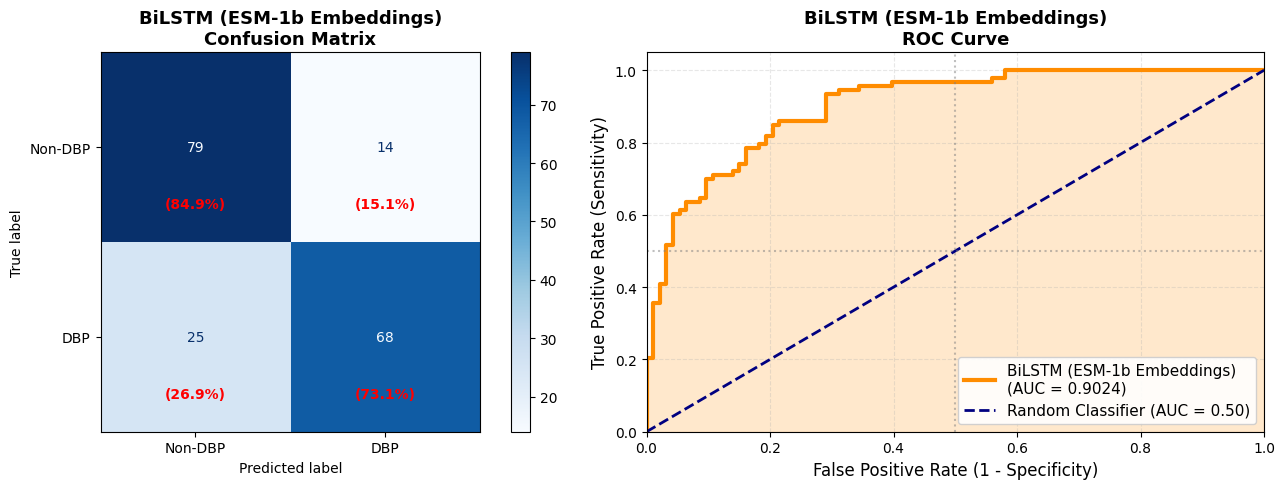


🔶 BASE MODEL 2: MLP (ESM-DBP)

DETAILED EVALUATION: MLP (ESM-DBP Embeddings)

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.8333    0.7527    0.7910        93
         DBP     0.7745    0.8495    0.8103        93

    accuracy                         0.8011       186
   macro avg     0.8039    0.8011    0.8006       186
weighted avg     0.8039    0.8011    0.8006       186


Confusion Matrix:
                Predicted 0     Predicted 1    
Actual 0        70              23             
Actual 1        14              79             

Detailed Metrics:
Metric               Value     
------------------------------
Sensitivity          0.8495
Specificity          0.7527
Precision            0.7745
Recall               0.8495
F1-Score             0.8103
Accuracy             0.8011
MCC                  0.6050
ROC-AUC              0.8762


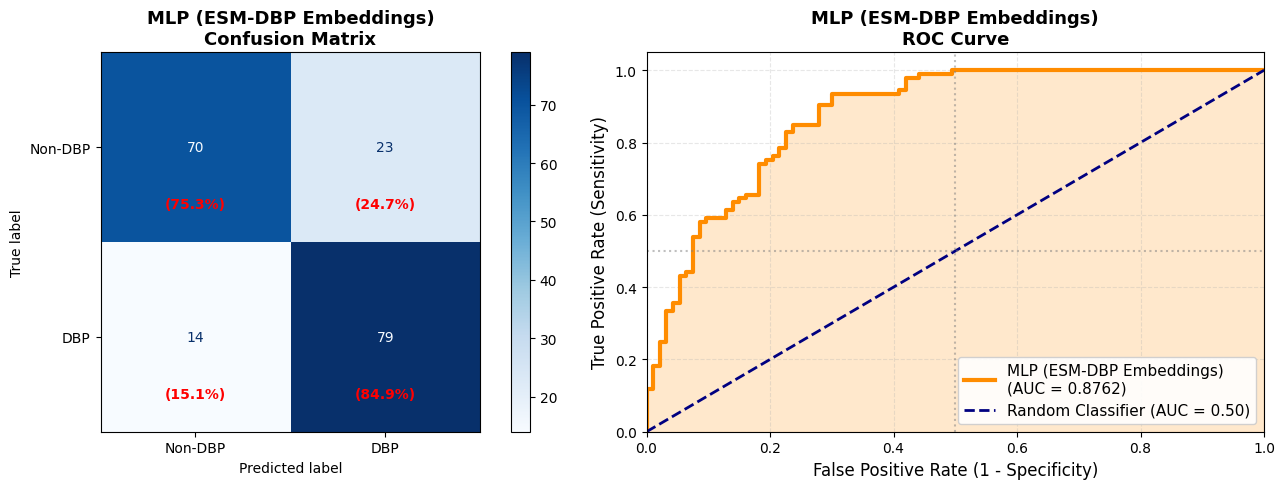


⚖️ WEIGHTED ENSEMBLE: 70% BiLSTM + 30% MLP

DETAILED EVALUATION: Weighted Ensemble (70:30 BiLSTM:MLP)

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.8000    0.8602    0.8290        93
         DBP     0.8488    0.7849    0.8156        93

    accuracy                         0.8226       186
   macro avg     0.8244    0.8226    0.8223       186
weighted avg     0.8244    0.8226    0.8223       186


Confusion Matrix:
                Predicted 0     Predicted 1    
Actual 0        80              13             
Actual 1        20              73             

Detailed Metrics:
Metric               Value     
------------------------------
Sensitivity          0.7849
Specificity          0.8602
Precision            0.8488
Recall               0.7849
F1-Score             0.8156
Accuracy             0.8226
MCC                  0.6470
ROC-AUC              0.9084


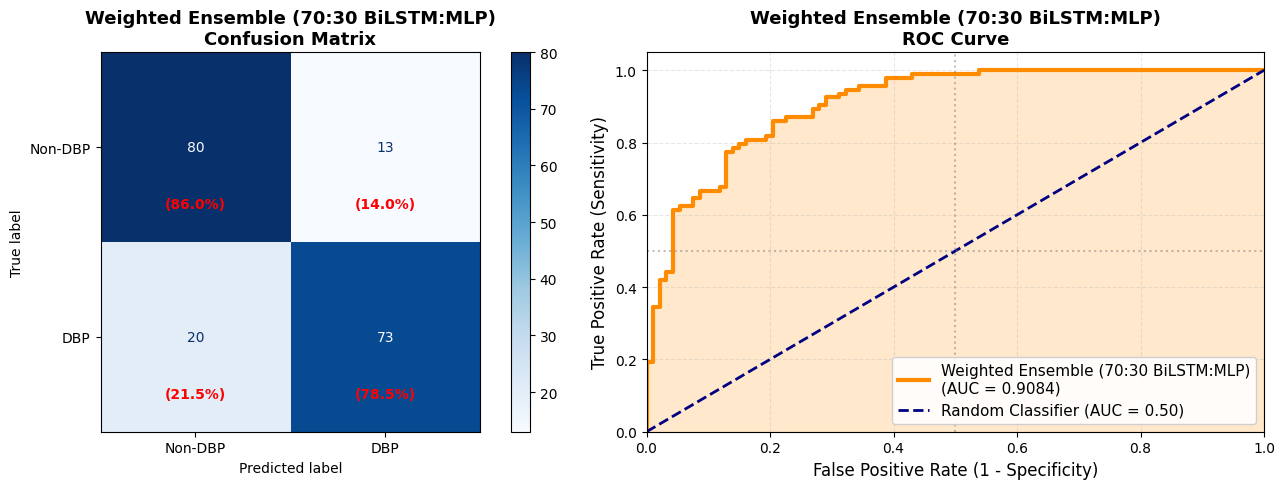


🎓 META-LEARNING: Stacking (Logistic Regression)

DETAILED EVALUATION: Stacking Ensemble (Logistic Regression)

Classification Report:
              precision    recall  f1-score   support

     Non-DBP     0.8065    0.8065    0.8065        93
         DBP     0.8065    0.8065    0.8065        93

    accuracy                         0.8065       186
   macro avg     0.8065    0.8065    0.8065       186
weighted avg     0.8065    0.8065    0.8065       186


Confusion Matrix:
                Predicted 0     Predicted 1    
Actual 0        75              18             
Actual 1        18              75             

Detailed Metrics:
Metric               Value     
------------------------------
Sensitivity          0.8065
Specificity          0.8065
Precision            0.8065
Recall               0.8065
F1-Score             0.8065
Accuracy             0.8065
MCC                  0.6129
ROC-AUC              0.9011


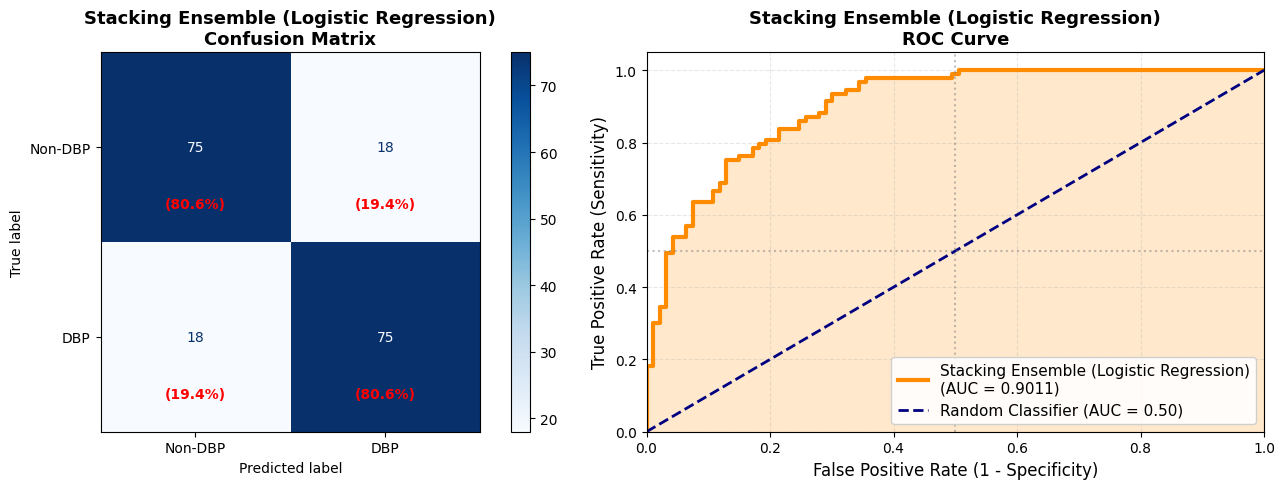

In [ ]:
    # 1. BiLSTM Evaluation
print("\n" + "🔷 BASE MODEL 1: BiLSTM (ESM-1b)")
bilstm_results = detailed_model_evaluation(
    y_test, lstm_test_preds, meta_test_lstm[:, 1],
    "BiLSTM (ESM-1b Embeddings)"
)

# 2. MLP Evaluation
print("\n" + "🔶 BASE MODEL 2: MLP (ESM-DBP)")
mlp_results = detailed_model_evaluation(
    y_test, mlp_test_preds, meta_test_mlp[:, 1],
    "MLP (ESM-DBP Embeddings)"
)

# 3. Weighted 70:30 Evaluation
print("\n" + "⚖️ WEIGHTED ENSEMBLE: 70% BiLSTM + 30% MLP")
weighted_results = detailed_model_evaluation(
    y_test, weighted_70_30_preds, weighted_70_30_probs,
    "Weighted Ensemble (70:30 BiLSTM:MLP)"
)

# 4. Stacking Evaluation (already done, but included for completeness)
print("\n" + "🎓 META-LEARNING: Stacking (Logistic Regression)")
stacking_results = detailed_model_evaluation(
    y_test, best_result['preds'], best_result['probs'],
    f"Stacking Ensemble ({best_name})"
)

